# <span style="font-width:bold; font-size: 3rem; color:#2656a3;">**Msc. BDS - M7 Second Semester Project** </span> <span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Inference Pipeline</span>

## <span style='color:#2656a3'> 🗒️ This notebook is divided into the following sections:

1. Load new data for final predictions.
2. Predict using model from Model Registry.

## <span style='color:#2656a3'> ⚙️ Import of libraries and packages

We start by accessing the folder we have created that holds the functions (incl. live API calls and data preprocessing) we need for the weather measures, calendar, and electricity price windows. Then, we proceed to import some of the necessary libraries needed for this notebook and warnings to avoid unnecessary distractions and keep output clean.

In [19]:
# First we go one back in our directory to access the folder with our functions
%cd ..

# Now we import the functions from the features folder
# This is the functions we have created to generate features for weather measures and calandar
from features import weather_measures, calendar, electricity_prices 

# We go back into the notebooks folder
%cd pipeline

/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/2. semester project/bds_m7_second-semester-project
/Users/camillahannesbo/Documents/AAU/Master - BDS/2. semester/2. semester project/bds_m7_second-semester-project/pipeline


In [20]:
# Importing pandas for data handling
import pandas as pd
import numpy as np

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

## <span style="color:#2656a3;"> 📡 Connecting to Hopsworks Feature Store
We connect to the Hopsworks Feature Store so we can retrieve the Feature View, access the Model Registry, and retrieve the saved model from training.

In [21]:
# Importing the hopsworks module
import hopsworks

# Logging into the Hopsworks project
project = hopsworks.login()

# Getting the feature store from the project
fs = project.get_feature_store() 

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/550040
Connected. Call `.close()` to terminate connection gracefully.


### <span style='color:#2656a3'> 📮 Retrieving Model from Model Registry

In [22]:
# Importing joblib to load the model
import joblib

# Retrieve the model registry
mr = project.get_model_registry()

# Retrieving the model from the Model Registry
retrieved_model = mr.get_model(
    name="xgb_electricity_price_model", 
    version=1,
)

Connected. Call `.close()` to terminate connection gracefully.


In [23]:
# Downloading the saved models to local directories
saved_model_dir = retrieved_model.download()

# Loading the saved XGBoost Regressor models
retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgb_electricity_price_model.pkl")

In [24]:
# Display the retrieved XGBoost Regressor model
retrieved_xgboost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style='color:#2656a3'> ✨ Load New Data
Our objective is to predict the electricity prices for the upcoming days, therefore we load a weather forecast as new data to make predictions.

In [25]:
# Fetching weather forecast measures for the next 5 days
weather_forecast_df = weather_measures.forecast_weather_measures(
    forecast_length=5
)

# Fetching danish calendar
calendar_df = calendar.calendar_denmark(
    freq='H',
)

# Fetching the moving average of the electricity prices
electricity_price_window_df = electricity_prices.electricity_prices_window(
    historical=False,
    area=["DK1"],
)

To make predictions based on the new date, we must match it to the schema of the training data. We start by merging the three dataframes `weather_forecast_df`, `calendar_df`, and `electricity_price_window_df` together. We drop and rename duplicate columns and further relocate the columns to match the schema of the training data.

In [26]:
# Merging the weather forecast and electricity price window dataframes
new_data = pd.merge(electricity_price_window_df, weather_forecast_df, how='inner', left_on='timestamp', right_on='timestamp')

In [27]:
# Merging the new data and calendar dataframes
new_data = pd.merge(new_data, calendar_df, how='inner', left_on='timestamp', right_on='timestamp')

# Displaying the new data
new_data.tail()

,timestamp,datetime_x,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,datetime_y,date_x,...,wind_speed_10m,wind_gusts_10m,datetime,date_y,hour_y,dayofweek,day,month,year,workday
115,1717095600000,2024-05-30 19:00:00,0.675998,0.448680,0.418180,0.445204,0.420669,0.427926,2024-05-30 19:00:00,2024-05-30,...,2.9,16.9,2024-05-30 19:00:00,2024-05-30,19,3,30,5,2024,1
116,1717099200000,2024-05-30 20:00:00,0.663541,0.449835,0.418369,0.444625,0.420588,0.427828,2024-05-30 20:00:00,2024-05-30,...,4.9,15.8,2024-05-30 20:00:00,2024-05-30,20,3,30,5,2024,1
117,1717102800000,2024-05-30 21:00:00,0.653535,0.451033,0.418560,0.444237,0.420556,0.427765,2024-05-30 21:00:00,2024-05-30,...,6.6,14.4,2024-05-30 21:00:00,2024-05-30,21,3,30,5,2024,1
118,1717106400000,2024-05-30 22:00:00,0.648060,0.452341,0.418806,0.443982,0.420540,0.427703,2024-05-30 22:00:00,2024-05-30,...,7.1,20.2,2024-05-30 22:00:00,2024-05-30,22,3,30,5,2024,1
119,1717110000000,2024-05-30 23:00:00,0.645492,0.453476,0.419106,0.443815,0.420532,0.427662,2024-05-30 23:00:00,2024-05-30,...,8.3,25.6,2024-05-30 23:00:00,2024-05-30,23,3,30,5,2024,1


In [28]:
# Dropping and renaming columns for the merged new data
new_data.drop(columns=['datetime_y', 'hour_y', 'date_y','datetime_x'], inplace=True)
new_data.rename(columns={
    'date_x': 'date', 
    'hour_x': 'hour'}, inplace=True)

# Displaying the new data
new_data.tail()

,timestamp,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,date,hour,temperature_2m,...,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,datetime,dayofweek,day,month,year,workday
115,1717095600000,0.675998,0.448680,0.418180,0.445204,0.420669,0.427926,2024-05-30,19,15.7,...,80.0,100.0,2.9,16.9,2024-05-30 19:00:00,3,30,5,2024,1
116,1717099200000,0.663541,0.449835,0.418369,0.444625,0.420588,0.427828,2024-05-30,20,15.2,...,80.0,99.0,4.9,15.8,2024-05-30 20:00:00,3,30,5,2024,1
117,1717102800000,0.653535,0.451033,0.418560,0.444237,0.420556,0.427765,2024-05-30,21,14.9,...,80.0,99.0,6.6,14.4,2024-05-30 21:00:00,3,30,5,2024,1
118,1717106400000,0.648060,0.452341,0.418806,0.443982,0.420540,0.427703,2024-05-30,22,14.8,...,3.0,99.0,7.1,20.2,2024-05-30 22:00:00,3,30,5,2024,1
119,1717110000000,0.645492,0.453476,0.419106,0.443815,0.420532,0.427662,2024-05-30,23,14.8,...,3.0,100.0,8.3,25.6,2024-05-30 23:00:00,3,30,5,2024,1


In [29]:
# Relocate columns to match training data schema
forecast_data = new_data[['hour', 'prev_1w_mean', 'prev_2w_mean', 'prev_4w_mean', 'prev_6w_mean',
       'prev_8w_mean', 'prev_12w_mean', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'rain', 'snowfall',
       'weather_code', 'cloud_cover', 'wind_speed_10m', 'wind_gusts_10m',
       'dayofweek', 'day', 'month', 'year', 'workday']]

In [30]:
# Display the first few rows of the DataFrame 'forecast_data'
forecast_data.head()

,hour,prev_1w_mean,prev_2w_mean,prev_4w_mean,prev_6w_mean,prev_8w_mean,prev_12w_mean,temperature_2m,relative_humidity_2m,precipitation,...,snowfall,weather_code,cloud_cover,wind_speed_10m,wind_gusts_10m,dayofweek,day,month,year,workday
0,0,0.510743,0.351968,0.398314,0.451050,0.422507,0.433568,17.5,88.0,0.0,...,0.0,2.0,56.0,11.9,21.2,6,26,5,2024,0
1,1,0.509817,0.351875,0.398395,0.451492,0.422451,0.433584,16.6,92.0,0.0,...,0.0,0.0,16.0,11.2,21.2,6,26,5,2024,0
2,2,0.508897,0.351975,0.398549,0.451934,0.422395,0.433601,16.0,94.0,0.0,...,0.0,1.0,25.0,10.4,19.4,6,26,5,2024,0
3,3,0.508046,0.352159,0.398793,0.452376,0.422348,0.433610,15.5,94.0,0.0,...,0.0,3.0,100.0,9.0,17.3,6,26,5,2024,0
4,4,0.507220,0.352357,0.399083,0.452810,0.422327,0.433621,15.8,94.0,0.0,...,0.0,3.0,100.0,11.5,20.5,6,26,5,2024,0


## <span style="color:#2656a3;">🤖 Making the predictions</span>

We now want to make predictions based on our trained model from Hopsworks and the forecasted weather measures.

In [31]:
# Make predictions using the retrieved XGBoost model on the 'forecast_data'
# The 'predict' method is called on the 'retrieved_xgboost_model' object, passing 'forecast_data' as input
predictions = retrieved_xgboost_model.predict(forecast_data)

# Print predictions
print(predictions)

[0.39047626 0.38083357 0.34324238 0.31227162 0.2887641  0.30623963
 0.34806588 0.34077927 0.28444025 0.2923457  0.23993938 0.1707754
 0.1714817  0.04958821 0.09417947 0.11988769 0.209875   0.40744996
 0.55270267 0.60159045 0.5910689  0.58989334 0.5667028  0.5200793
 0.41889793 0.36752382 0.39200506 0.39420804 0.4024162  0.49420124
 0.6111074  0.6420042  0.66721696 0.64529973 0.5342415  0.4768422
 0.41492337 0.36524674 0.28044072 0.40817922 0.46006832 0.5509835
 0.5678965  0.6939259  0.70034534 0.6599615  0.62402725 0.552754
 0.50494415 0.47587788 0.45668185 0.43385822 0.41746742 0.43732214
 0.5518054  0.64782655 0.6715337  0.5438552  0.47371155 0.3287433
 0.34696344 0.2318723  0.25873846 0.1749926  0.29627585 0.39241582
 0.5139463  0.62589765 0.51722014 0.5183054  0.6255746  0.5542937
 0.51594234 0.488373   0.47072893 0.42540842 0.42853168 0.47586018
 0.6132057  0.7123545  0.7149276  0.6662925  0.5841808  0.5312926
 0.46631047 0.30291566 0.30918053 0.35891575 0.48197472 0.59101045
 0.6

In [32]:
# Assign the predictions to the 'predictions' column in the new_data dataframe
new_data['predictions'] = predictions

# Show the dataframe with the predictions
new_data[['datetime', 'predictions']]

,datetime,predictions
0,2024-05-26 00:00:00,0.390476
1,2024-05-26 01:00:00,0.380834
2,2024-05-26 02:00:00,0.343242
3,2024-05-26 03:00:00,0.312272
4,2024-05-26 04:00:00,0.288764
...,...,...
115,2024-05-30 19:00:00,0.676136
116,2024-05-30 20:00:00,0.665157
117,2024-05-30 21:00:00,0.643518
118,2024-05-30 22:00:00,0.549648


### <span style="color:#2656a3;">📊 Plot the predictions</span>

Now we plot the predictions as a linechart for the comming five days.
We are plotting the linechart with both matplotlib and Altair for interactive visualization.

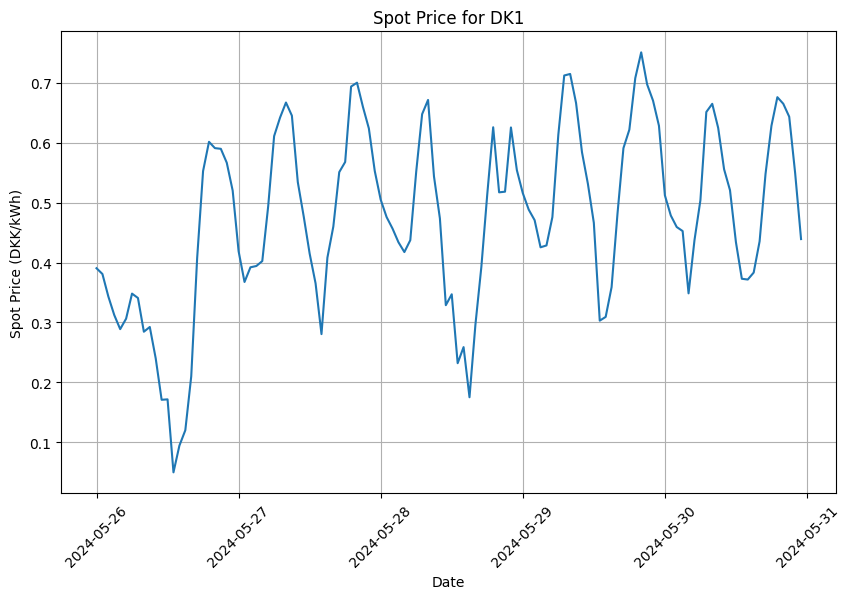

In [33]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Group the data by date and calculate the average temperature for each day
daily_data = new_data.groupby('datetime')['predictions'].mean()
 
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data.values)

# Adding labels and title
plt.title('Spot Price for DK1')
plt.xlabel('Date')
plt.ylabel('Spot Price (DKK/kWh)')
plt.xticks(rotation=45)
plt.grid(True)
 
# Show the plot
plt.show()

In [34]:
# Importing Altair for interactive visualization
import altair as alt

# Create Altair chart with line and dots
chart = alt.Chart(new_data).mark_line(point=True).encode(
    x='datetime:T', 
    y='predictions:Q', 
    # Adding tooltips for interactive information display
    tooltip=[alt.Tooltip('dateime:T', title='Date', format='%Y-%m-%d'), 
             alt.Tooltip('datetime:T', title='Time', format='%H:%M'), 
             alt.Tooltip('predictions:Q', title='Spot Price (DKK/kWh)', format='.2f'),
            ]
)
 
# Display the chart
chart.interactive()

alt.Chart(...)

---
## <span style="color:#2656a3;">⏭️ **Next:** Creating our Python files for a Streamlit application ([link to Github repository](https://github.com/tobiasmj97/bds_m7_second-semester-project_streamlit)) </span>
